## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")

In [3]:
# Set a random seed for reproducibility
random_seed = 2610

# Specify the number of tweets for your sample (adjust as needed)
sample_size = 7000

# Create a reproducible sample
congress_tweets_sample = congress_tweets.sample(n=sample_size, random_state=random_seed)

# Display the first few rows of the sample
congress_tweets_sample.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
933554,1.131590e+18,SenatorBaldwin,2019-05-23T11:49:37-04:00,Wisconsin lost 90 dairy farms in April. And as...,Tammy Baldwin,Sen,3-Jan-13,2/11/1962,F,WI,Senate,Democrat,"1,405,284","1,382,536","1,620,985","1,407,966"
73940,1.131240e+18,RepJudyChu,2019-05-22T12:59:00-04:00,We got the beat. Now we need to make sure they...,Judy Chu,Rep,14-Jul-09,7/7/1953,F,CA,27,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
481922,1.334620e+18,RepAdrianSmith,2020-12-03T17:15:02-05:00,Thanks to @randolphpublic for the opportunity ...,Adrian Smith,Rep,3-Jan-07,12/19/1970,M,NE,3,Republican,"495,961","284,494","302,081","475,064"
106677,1.222180e+18,SenFeinstein,2020-01-28T10:15:23-05:00,My colleagues and I wrote to @HHSGov to expres...,Dianne Feinstein,Sen,4-Nov-92,6/22/1933,F,CA,Senate,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
55594,1.082480e+18,RepDeSaulnier,2019-01-07T22:38:02-05:00,"Thank you @JerryBrownGov for your leadership, ...",Mark DeSaulnier,Rep,3-Jan-15,3/31/1952,M,CA,11,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"


In [4]:
# Display information about the DataFrame
congress_tweets_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 933554 to 777852
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tweet_id                  7000 non-null   float64
 1   screen_name               7000 non-null   object 
 2   datetime                  7000 non-null   object 
 3   text                      7000 non-null   object 
 4   name_wikipedia            7000 non-null   object 
 5   position                  7000 non-null   object 
 6   joined_congress_date      7000 non-null   object 
 7   birthday                  7000 non-null   object 
 8   gender                    7000 non-null   object 
 9   state                     7000 non-null   object 
 10  district_number           7000 non-null   object 
 11  party                     7000 non-null   object 
 12  trump_2016_state_share    7000 non-null   object 
 13  clinton_2016_state_share  7000 non-null   object 
 14  obama_

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [5]:
import spacy
import string

In [6]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith(('twitter','twimg', 'pbs', 'png' 'http', 'https', 'html','www'))]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [7]:
congress_tweets_sample['tokens'] = congress_tweets_sample['text'].map(lambda x: rem_punc_stop(x))

In [8]:
for entity in nlp('tokens').ents:
    print(entity.text + ' - ' + entity.label_ + ' - ' + str(spacy.explain(entity.label_)))

tokens - GPE - Countries, cities, states


In [9]:
congress_tweets_sample['tokens'] 

933554    [Wisconsin, lost, 90, dairy, farms, April, And...
73940     [We, got, beat, Now, need, sure, fair, compens...
481922    [Thanks, randolphpublic, opportunity, visit, t...
106677    [My, colleagues, I, wrote, HHSGov, express, de...
55594     [Thank, JerryBrownGov, leadership, service, ti...
                                ...                        
191516    [One, health, care, social, service, workers, ...
760682    [RT, taxreformer, Starbucks, GOP, Tax, Cuts, A...
632820    [Today, DecencyDay, Whether, halls, Congress, ...
481609    [Thank, UNL, President, Carter, Chancellor, Gr...
777852    [The, American, people, deserve, transparency,...
Name: tokens, Length: 7000, dtype: object

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [11]:
# apply function to text object
text = ' '.join(congress_tweets_sample['tokens'].map(lambda text: ' '.join(text)))

In [12]:
# create WordCloud visualization using the "text" object 
# not sure why stop words are still being included 
wordcloud = WordCloud(random_state=40).generate(text) # set random state to ensure same word cloud each time


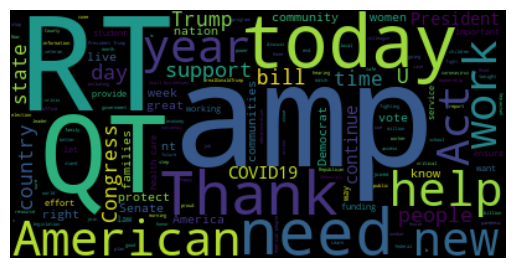

In [13]:
# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

### EDA 2

In [14]:
# Import necessary libraries
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [15]:
# initalize CountVectorizer and specify some parameters
# ----------
bow_vector = CountVectorizer(tokenizer = rem_punc_stop, # use our function for tokenizing created above
                             token_pattern = None,      # set to "None" since we have specify our own pattern
                             ngram_range=(1,1))         # use default for unigrams - se

In [16]:
# fit and transform just a subset of our data
# ----------
bow_matrix = bow_vector.fit_transform(congress_tweets['text'][0:5]) 

In [17]:
# visualize
# ----------
bow_matrix.todense() # todense() densifies the sparse matrix (which only stores non-zero

matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
         1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 2, 1, 1, 1, 0, 0, 4, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
         1, 0, 0, 1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]

In [18]:
# get feature names instead and view subset
# ----------
feature_names = bow_vector.get_feature_names_out()
feature_names[0:10] 

array(['\n', '60', 'a220', 'a220300', 'a220300s', 'action', 'agreement',
       'airbus', 'aircraft', 'airliner'], dtype=object)

In [19]:
# Code to concatenate bag of words matrix with column names to visualize
# ----------
bow_df = pd.DataFrame(bow_matrix.toarray(),  # make bow_matrix an array 
                      columns=feature_names) # set column names to feature names just extracted
bow_df

,\n,60,a220,a220300,a220300s,action,agreement,airbus,aircraft,airliner,...,things,thrive,today,trump,understand,vote,votes,washington,wo,work
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,1,2,1,1,1,0,0,4,1,1,...,0,0,1,0,0,0,0,0,0,1
2,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,1,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,2,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


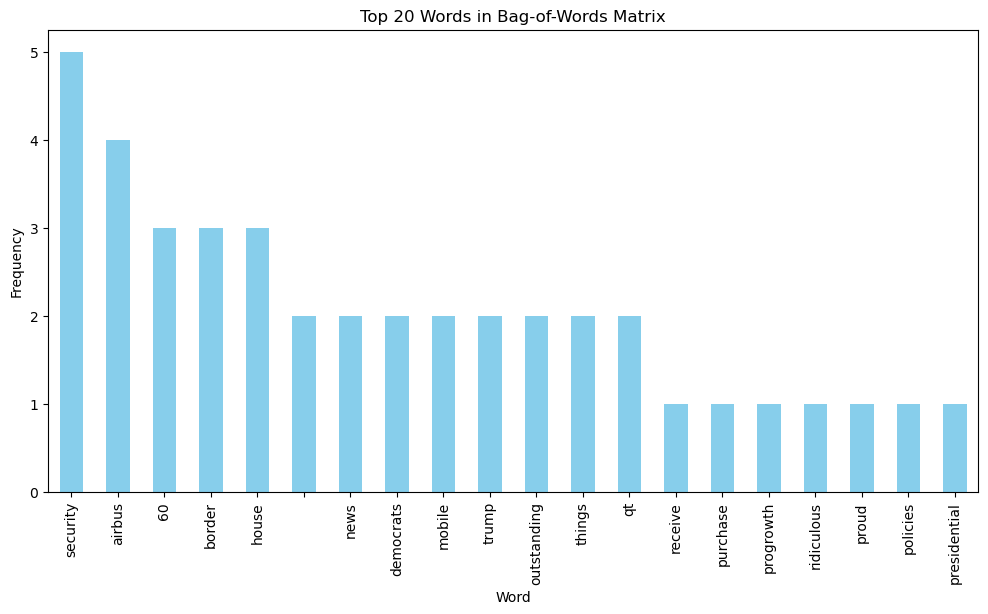

In [20]:
top_words = bow_df.sum().sort_values(ascending=False).head(20)
top_words.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Top 20 Words in Bag-of-Words Matrix')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from spacy.lang.en.stop_words import STOP_WORDS

congress_tweets_sample['tokens'] = congress_tweets_sample['tokens'].apply(lambda tokens: ' '.join(tokens))

countvec = CountVectorizer(stop_words=list(STOP_WORDS), ngram_range=(2, 3))
ngrams = countvec.fit_transform(congress_tweets_sample['tokens'])
dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns=countvec.get_feature_names_out())


C:\Users\albar\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [22]:
# create dataframe of n-grams and their frequency 
# ----------

# create a datamframe by summing over the dictionary_dataframe from above and resetting the index
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})

#  sort by frequency 
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)

# view the first few lines
df_ngram.head()

,ngrams,freq
0,health care,182
1,president trump,153
2,small businesses,133
3,american people,127
4,united states,102


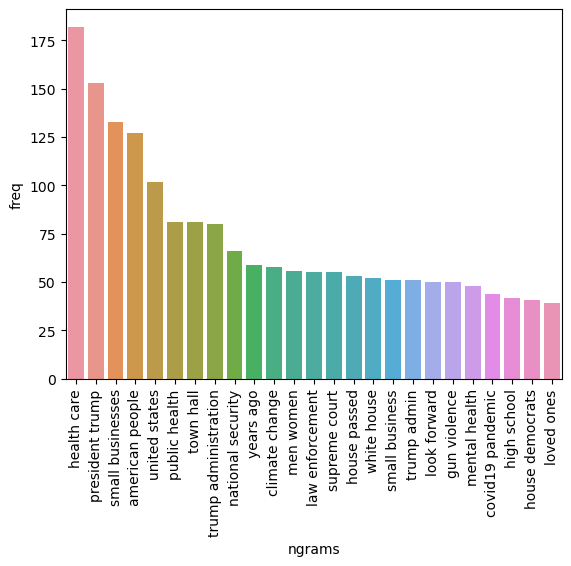

In [23]:
# create bar plot visualization
# ----------
sns.barplot(x="ngrams", 
            y = 'freq', 
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

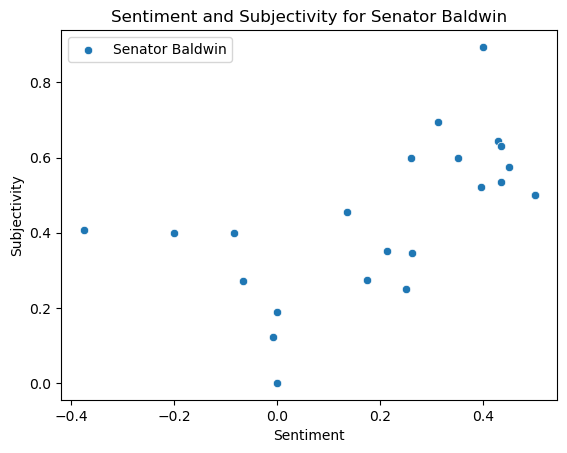

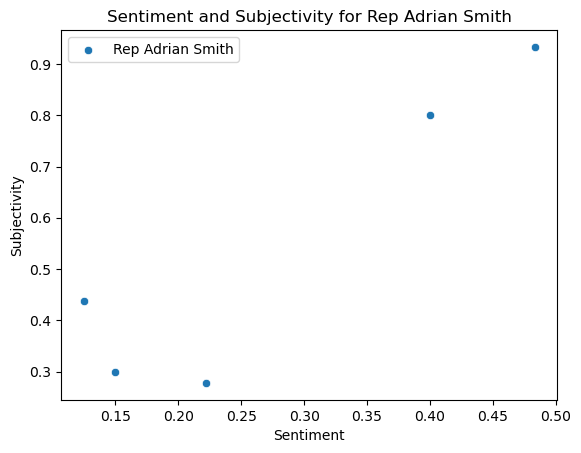

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob


# Function to get sentiment scores using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment

# Apply sentiment analysis to each tweet
congress_tweets_sample['sentiment'] = congress_tweets_sample['text'].apply(get_sentiment)

# Create separate columns for sentiment and subjectivity
congress_tweets_sample[['sentiment', 'subjectivity']] = congress_tweets_sample['sentiment'].apply(lambda x: pd.Series([x.polarity, x.subjectivity]))

# Plot scatterplot for liberal legislator (e.g., Senator Baldwin)
sns.scatterplot(x='sentiment', y='subjectivity', data=congress_tweets_sample[congress_tweets_sample['screen_name'] == 'SenatorBaldwin'], label='Senator Baldwin')
plt.title('Sentiment and Subjectivity for Senator Baldwin')
plt.xlabel('Sentiment')
plt.ylabel('Subjectivity')
plt.legend()
plt.show()

# Plot scatterplot for conservative legislator (e.g., Representative Smith)
sns.scatterplot(x='sentiment', y='subjectivity', data=congress_tweets_sample[congress_tweets_sample['screen_name'] == 'RepAdrianSmith'], label='Rep Adrian Smith')
plt.title('Sentiment and Subjectivity for Rep Adrian Smith')
plt.xlabel('Sentiment')
plt.ylabel('Subjectivity')
plt.legend()
plt.show()


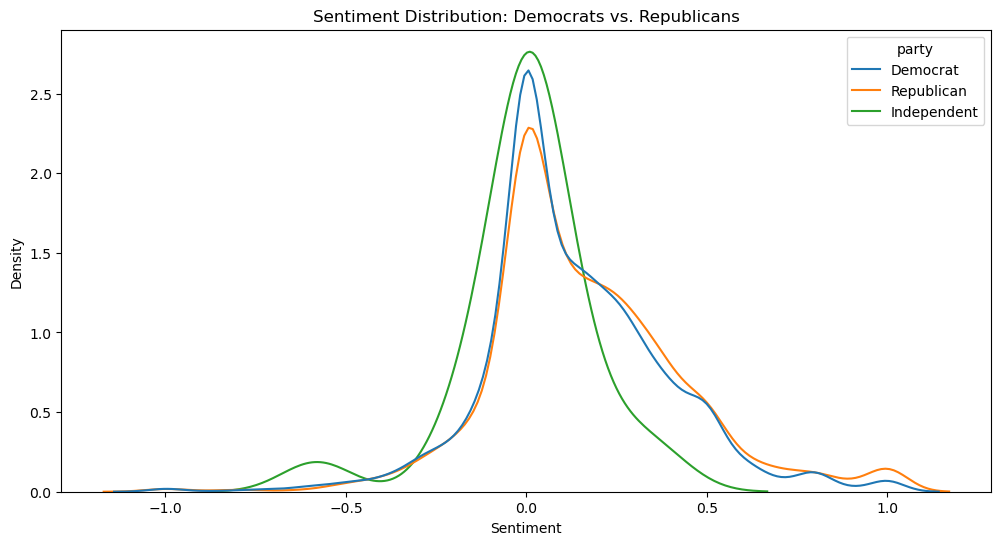

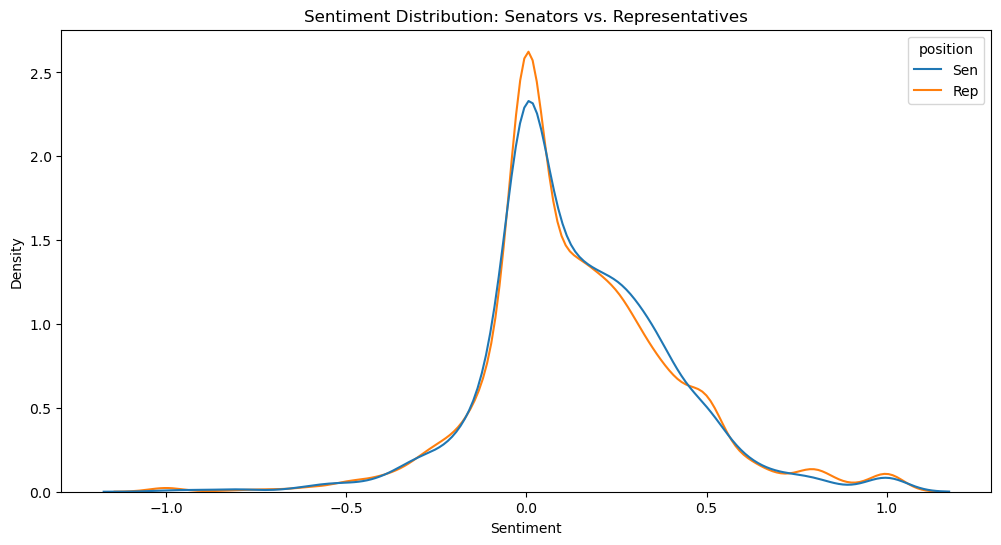

In [25]:
# Plot density plots for Democrats vs. Republicans
plt.figure(figsize=(12, 6))
sns.kdeplot(data=congress_tweets_sample, x='sentiment', hue='party', common_norm=False)
plt.title('Sentiment Distribution: Democrats vs. Republicans')
plt.xlabel('Sentiment')
plt.ylabel('Density')
plt.show()

# Plot density plots for Senators vs. Representatives
plt.figure(figsize=(12, 6))
sns.kdeplot(data=congress_tweets_sample, x='sentiment', hue='position', common_norm=False)
plt.title('Sentiment Distribution: Senators vs. Representatives')
plt.xlabel('Sentiment')
plt.ylabel('Density')
plt.show()


## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [26]:
# Engineered Features


### Bag-of-words or Tf-idf

In [27]:
# Frequency Based featurization
...

In [28]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [29]:
bow_matrix = bow_vector.fit_transform(texts)

NameError: name 'texts' is not defined

In [ ]:
print("Bag-of-Words Matrix:")
bow_matrix.todense()

In [ ]:
# Get feature names directly from the vocabulary
feature_namesbow = bow_vector.get_feature_names_out()

In [ ]:
# Display feature names
print("\nFeature Names from BOW:")
print(feature_namesbow)

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer = rem_punc_stop)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample data
texts = congress_tweets_sample['text'][0:5]

# Create TF-IDF vectorizer
tfidf_vector = TfidfVectorizer(tokenizer=rem_punc_stop)

# Fit and transform the data
matrix = tfidf_vector.fit_transform(texts)

# Get feature names directly from the vocabulary
feature_names = tfidf_vector.get_feature_names_out()

# Display the number of features
len(feature_names)


In [ ]:
matrix.todense()

### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [ ]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [ ]:
# embedding based featurization
...
from gensim.models import Word2Vec

# Assuming 'congress_tweets_sample' is your DataFrame and 'word_vectors' is a pre-trained Word2Vec model
embedding_dim = len(word_vectors['example'])  # Adjust to the actual dimension of your word vectors

# Function to average word vectors for a given text
def average_word_vectors(text, word_vectors, embedding_dim):
    words = text.split()
    vectors = [word_vectors[word] for word in words if word in word_vectors]
    if not vectors:
        return np.zeros(embedding_dim)
    return np.mean(vectors, axis=0)

# Apply the function to create document embeddings
congress_tweets_sample['embedding'] = congress_tweets_sample['text'].apply(lambda x: average_word_vectors(x, word_vectors, embedding_dim))

# Convert the 'embedding' column to a dataframe
embedding_df = pd.DataFrame(congress_tweets_sample['embedding'].tolist(), columns=[f'embedding_{i}' for i in range(embedding_dim)])


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**